# Linear mixed effects model on reaction times

Analysing reaction time measures from comprehension questions.

In [1]:
import sys
import os.path as op
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")

sys.path.append('/imaging/hauk/rl05/fake_diamond/scripts/preprocessing')
import config

logs_dir = config.logs_dir

subjects = config.subject_ids
subjects_to_ignore = ['25']
subjects = [subject for subject in subjects if subject not in subjects_to_ignore]
print(f'subjects (n={len(subjects)}): ', subjects)
runs = [1,2,3,4,5]

subjects (n=25):  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26']


In [2]:
subjects_logs = []

for subject in subjects:
    
    subject = f'sub-{subject}'
    
    logs_fname = op.join(logs_dir, f'{subject}_logfile.csv')
    log_tmp = pd.read_csv(logs_fname)
    log_tmp = log_tmp.drop(columns='Unnamed: 10')
    
    subjects_logs.append(log_tmp)
    
data = pd.concat(subjects_logs)
del subjects_logs


# get conditions because i forgot to save them in logfiles :(
stimuli = pd.read_csv('/home/rl05/ownCloud/projects/fake_diamond/scripts/stimulus_presentation/stimuli_test.csv')
data.set_index('item_nr', inplace=True)
# data['answer'] = data.index.map(stimuli['answer'])
# data['condition'] = data.index.map(stimuli['condition_name'])
# data['experiment'] = data.index.map(stimuli['experiment'])
# data['experiment'] = data['experiment'].replace('concreteness_denotation','compose')
data.reset_index(inplace=True)

# log transform RT
data['LogRT'] = np.log(data['RT'])

# only keep correct responses
data = data[data.hit == 1.0] # only analysing reaction times from trials answered correctly

# calculate length of task questions
# data_compose['probe_length'] = data_compose['probe'].str.len() # number of letters
data['probe_length'] = data['probe'].str.split().apply(len) # number of words

# remove outliers


data

,item_nr,participant,block_nr,trial_nr,set_nr,word1,word2,probe,response,RT,hit,condition,experiment,LogRT,probe_length
2,745,1,1,3,49,htbqzylm,horse,Does it have scales?,Ry,1.903904,1.0,low,specificity,0.643907,4
16,895,1,1,17,99,xkq,weather,Is it predictable?,Ry,1.475055,1.0,low,specificity,0.388695,3
24,463,1,1,25,78,real,shotgun,Is it to be handled with care?,Rb,2.479371,1.0,concrete_subsective,compose,0.908005,7
45,698,1,1,46,33,guide,dog,Is it disobedient?,Ry,1.699456,1.0,mid,specificity,0.530308,3
54,367,1,1,55,62,typical,pudding,Is it edible?,Rb,1.627648,1.0,concrete_subsective,compose,0.487136,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22471,60,26,5,152,10,ypdcglkc,scandal,Is it morally dubious?,Rb,2.110366,1.0,abstract_baseline,compose,0.746861,4
22476,745,26,5,157,49,htbqzylm,horse,Does it have scales?,Ry,1.490020,1.0,low,specificity,0.398790,4
22478,698,26,5,159,33,guide,dog,Is it disobedient?,Ry,1.845073,1.0,mid,specificity,0.612519,3
22495,735,26,5,176,45,zrtqgfplh,ruby,Is it for eating?,Ry,1.020272,1.0,high,specificity,0.020069,4


In [3]:
data.groupby(['participant'])['hit'].sum()/90*100

participant
1     64.444444
2     83.333333
3     65.555556
4     76.666667
5     78.888889
6     77.777778
7     80.000000
8     80.000000
9     75.555556
10    84.444444
11    78.888889
12    81.111111
13    84.444444
14    81.111111
15    74.444444
16    82.222222
17    72.222222
18    85.555556
19    83.333333
20    82.222222
21    73.333333
22    81.111111
23    71.111111
24    68.888889
26    74.444444
Name: hit, dtype: float64

In [4]:
data.groupby(['probe'])['hit'].sum()/84*100

probe
Are they poor?                         8.333333
Can it be from a story?               22.619048
Can it be used as a prop on stage?    23.809524
Can it be used in a battle?           16.666667
Can you easily move it around?        20.238095
                                        ...    
Is it violent?                        28.571429
Is there disagreement?                20.238095
Should it be neglected?               26.190476
Should it be repeated?                23.809524
Should it be taught in school?        15.476190
Name: hit, Length: 85, dtype: float64

First look at reaction time data. We expect a positively skewed distribution.

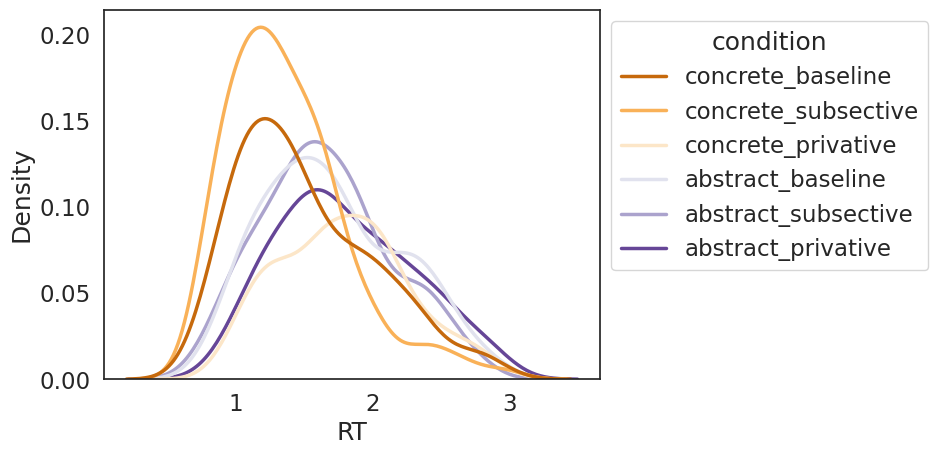

In [18]:
# plt.Figure(figsize=(10,5))
hue_order = ['concrete_baseline','concrete_subsective','concrete_privative',
             'abstract_baseline','abstract_subsective','abstract_privative',]
axis = sns.kdeplot(data=data[data.experiment=='compose'], x='RT', hue='condition', palette='PuOr',
                  hue_order=hue_order
                  )
sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))

Task questions in this study have variable lengths. That is, the number of words per question may differ across conditions. Let's look at the variance and see if it differs across conditions.

In [6]:
print('Number of total trials entering analysis:', len(data))
print(data[['word1','word2','probe','probe_length']].head(7))

Number of total trials entering analysis: 1747
        word1    word2                           probe  probe_length
2    htbqzylm    horse            Does it have scales?             4
16        xkq  weather              Is it predictable?             3
24       real  shotgun  Is it to be handled with care?             7
45      guide      dog             Is it disobedient?              3
54    typical  pudding                   Is it edible?             3
59  vpbyzkgrf  shotgun                     Is it safe?             3
86    tqvgqrz    skill           Do musicians have it?             4


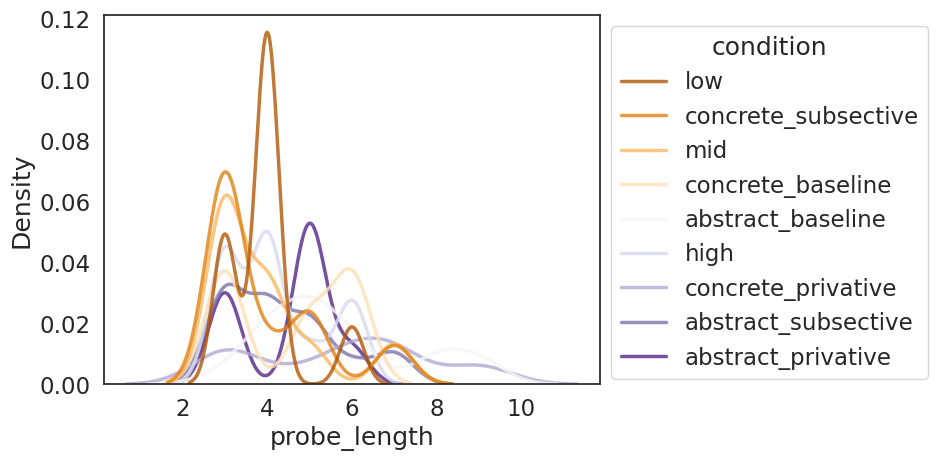

In [7]:
axis = sns.kdeplot(data=data, 
                   x='probe_length', 
                   hue='condition', 
                   fill=False, 
                   alpha=0.8, 
                   palette='PuOr')
sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))

We deal with this by regressing question length (operationalised as number of letters in questions) out of reaction time data. 

In [8]:
X = data['probe_length']  
X = sm.add_constant(X)  # add a constant term (intercept) to the model
y = data['LogRT'] # this 

model = sm.OLS(y, X).fit()

# get the residuals (regressed out RT)
data['LogRT_residual'] = model.resid
data[['probe_length','LogRT','LogRT_residual']].head(5)

,probe_length,LogRT,LogRT_residual
2,4,0.643907,0.285849
16,3,0.388695,0.082768
24,7,0.908005,0.393557
45,3,0.530308,0.224381
54,3,0.487136,0.181209


In [9]:
data.groupby('condition')[['LogRT','LogRT_residual']].describe()

LogRT                                                    \
                     count      mean       std       min       25%       50%   
condition                                                                      
abstract_baseline    186.0  0.489978  0.298763 -0.193830  0.281943  0.500220   
abstract_privative   160.0  0.551330  0.281924 -0.177021  0.376279  0.554654   
abstract_subsective  183.0  0.465481  0.293379 -0.340926  0.273066  0.474184   
concrete_baseline    193.0  0.361790  0.322469 -0.320125  0.115114  0.343045   
concrete_privative   132.0  0.544267  0.266337 -0.042450  0.341153  0.565200   
concrete_subsective  229.0  0.271947  0.299275 -0.357918  0.064052  0.254298   
high                 218.0  0.292815  0.297880 -0.389805  0.054418  0.279493   
low                  224.0  0.272442  0.307309 -0.401657  0.065689  0.287752   
mid                  222.0  0.330033  0.307861 -0.647025  0.111996  0.311410   

                                        LogRT_residual                      \
                          75%       max          count      mean       std   
condition                                                                    
abstract_baseline    0.744489  1.061005          186.0  0.045878  0.300442   
abstract_privative   0.763843  1.084881          160.0  0.167860  0.288622   
abstract_subsective  0.656661  1.017980          183.0  0.088623  0.286893   
concrete_baseline    0.612516  1.073695          193.0 -0.026789  0.310250   
concrete_privative   0.735924  1.055121          132.0  0.095772  0.254136   
concrete_subsective  0.474184  1.094608          229.0 -0.082695  0.289896   
high                 0.504747  1.016179          218.0 -0.074568  0.294085   
low                  0.456015  1.071649          224.0 -0.082357  0.307324   
mid                  0.544149  1.096942          222.0 -0.024502  0.314014   

                                                                       
                          min       25%       50%       75%       max  
condition                                                              
abstract_baseline   -0.631041 -0.146609  0.046170  0.270629  0.727431  
abstract_privative  -0.587208 -0.021997  0.144704  0.412410  0.761617  
abstract_subsective -0.698984 -0.106478  0.121234  0.279016  0.659923  
concrete_baseline   -0.731561 -0.254108 -0.066435  0.210791  0.611377  
concrete_privative  -0.482717 -0.095891  0.118410  0.259188  0.688721  
concrete_subsective -0.872365 -0.287476 -0.087857  0.117976  0.769811  
high                -0.695732 -0.292106 -0.082731  0.126335  0.643854  
low                 -0.860998 -0.298472 -0.072247  0.098686  0.713592  
mid                 -0.952952 -0.230358 -0.028558  0.208448  0.738885

# Composition

In [10]:
data_compose = data[data.experiment == 'compose'].copy()
data_compose[['concreteness', 'denotation']] = data_compose.loc[:,'condition'].str.split('_', n=1, expand=True)
data_compose.head(3)

,item_nr,participant,block_nr,trial_nr,set_nr,word1,word2,probe,response,RT,hit,condition,experiment,LogRT,probe_length,LogRT_residual,concreteness,denotation
24,463,1,1,25,78,real,shotgun,Is it to be handled with care?,Rb,2.479371,1.0,concrete_subsective,compose,0.908005,7,0.393557,concrete,subsective
54,367,1,1,55,62,typical,pudding,Is it edible?,Rb,1.627648,1.0,concrete_subsective,compose,0.487136,3,0.181209,concrete,subsective
59,465,1,1,60,78,vpbyzkgrf,shotgun,Is it safe?,Ry,1.676517,1.0,concrete_baseline,compose,0.516719,3,0.210791,concrete,baseline


In [11]:
summary_stats = data_compose.groupby('concreteness')['RT'].agg(Mean='mean', SD='std').reset_index()
print(summary_stats)

  concreteness      Mean        SD
0     abstract  1.719286  0.490586
1     concrete  1.519905  0.490641


In [12]:
summary_stats = data_compose.groupby('denotation')['RT'].agg(Mean='mean', SD='std').reset_index()
print(summary_stats)

   denotation      Mean        SD
0    baseline  1.607071  0.508233
1   privative  1.794660  0.480179
2  subsective  1.500993  0.471640


Visualise distribution of reaction times by condition

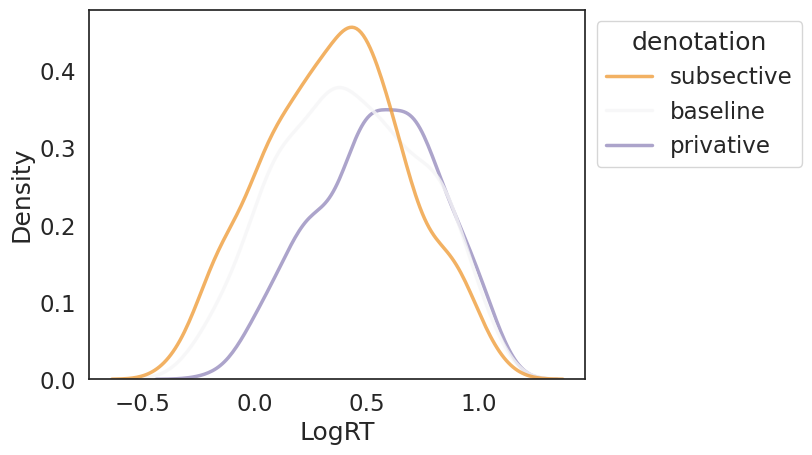

In [15]:
# hue_order = ['concrete_baseline','concrete_subsective','concrete_privative',
#              'abstract_baseline','abstract_subsective','abstract_privative',]
# colors = np.array([plt.cm.Oranges(np.linspace(0.3, 0.9, 3)),
#                   plt.cm.Blues(np.linspace(0.3, 0.9, 3))])
axis = sns.kdeplot(data=data_compose, x='LogRT', hue='denotation', 
#                    hue_order=hue_order,
#                    color=colors,
                   fill=False, alpha=0.8, 
                   palette='PuOr'
                  )
sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))

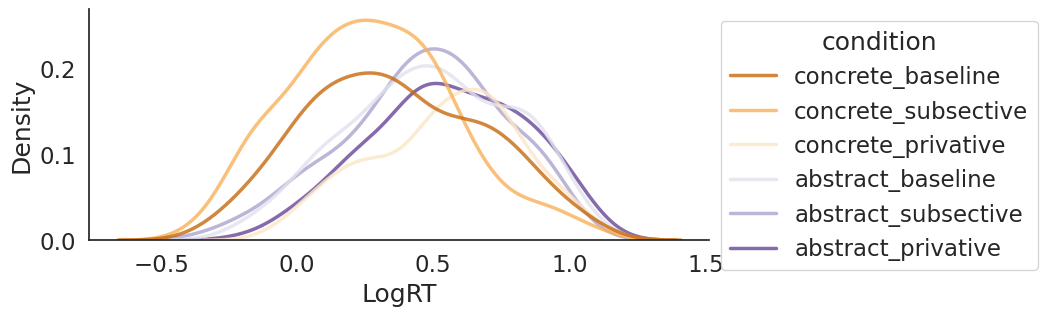

In [16]:
plt.figure(figsize=(8, 3))
hue_order = ['concrete_baseline','concrete_subsective','concrete_privative',
             'abstract_baseline','abstract_subsective','abstract_privative',]
axis = sns.kdeplot(data=data_compose, x='LogRT', hue='condition', 
            hue_order=hue_order,
            fill=False, alpha=0.8, palette='PuOr')
sns.despine()
sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
plt.show()